Mounted at /content/drive/


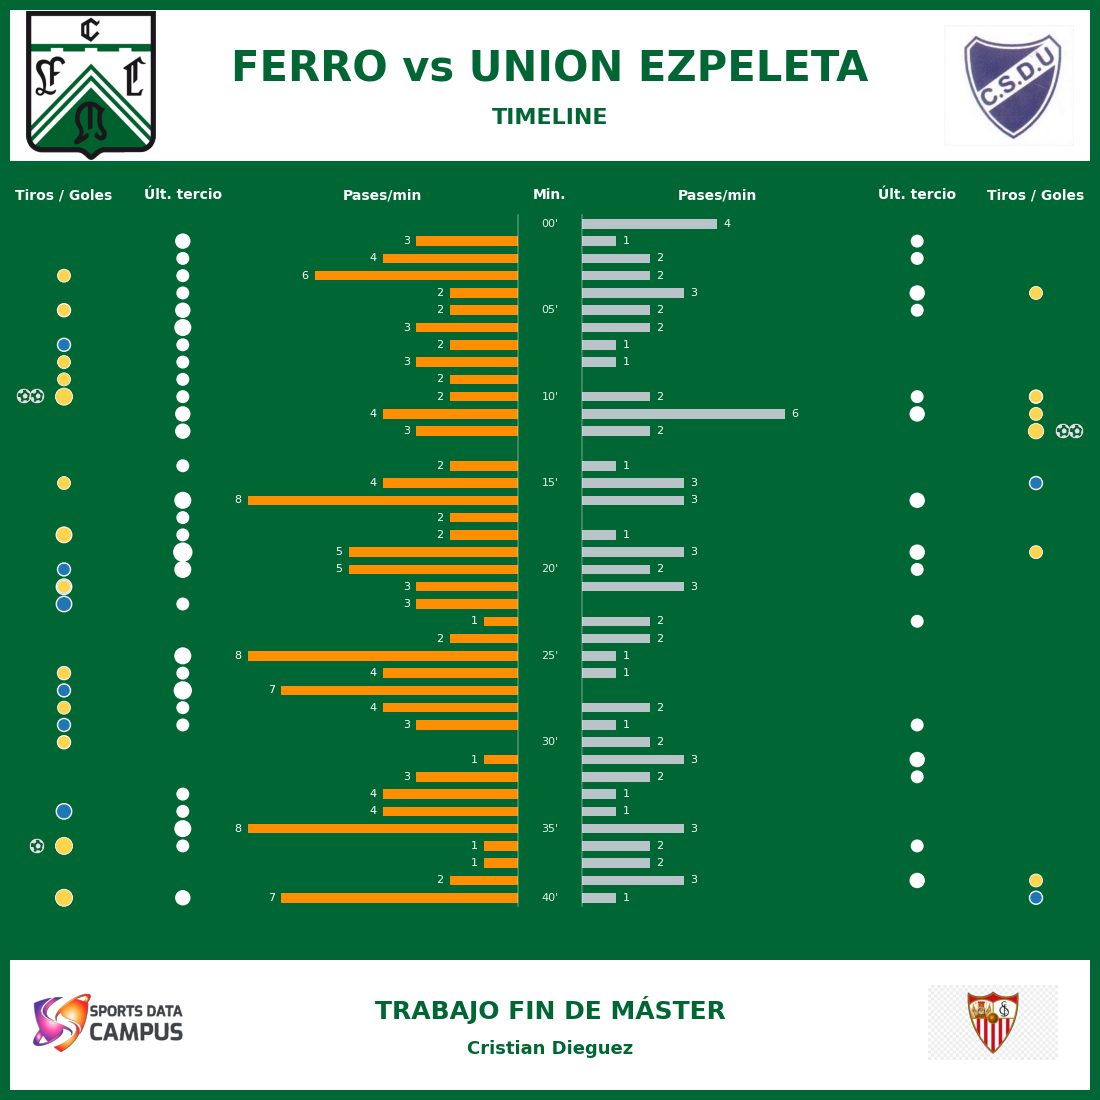

In [2]:
# ================================================
# TIMELINE FUTSAL (0' arriba → 40' abajo)
# Banners + títulos alineados + barras desde el centro
# ================================================
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
# ---------- RUTAS ----------
XML_EQUIPO    = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"
MATRIX_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - Matrix.xlsx"

LOGO_FERRO_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ferro.png"
LOGO_RIVAL_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ezpeleta.png"

# Banner inferior (marca personal)
LOGO_LEFT_FOOTER  = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/SportData.png"
LOGO_RIGHT_FOOTER = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/Sevilla.png"

# ⚽ PNG de pelota (colocá tu archivo aquí)
BALL_ICON_PATH    = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/pelota.png"

# ---------- IMPORTS ----------
import os, re, unicodedata, numpy as np, pandas as pd, xml.etree.ElementTree as ET
import matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle   # ### CAMBIO (Circle)
from PIL import Image
from math import sqrt                              # ### NUEVO

INCLUDE_GOALS_IN_SHOT_CIRCLES = True   # <— ponelo al inicio del script

# ---------- UTILIDADES ----------
def ntext(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()
def nlower(s): return ntext(s).lower()

def infer_opponent(*paths):
    cand = None
    for p in paths:
        if not p: continue
        base = os.path.basename(p); name = os.path.splitext(base)[0]
        parts = [x.strip() for x in re.split(r"\s*-\s*", name)]
        if parts: cand = parts[0]
        cand = re.sub(r"(?i)categoria\s*\-\s*equipo\s*rival", "", cand or "").strip()
        if cand: break
    cand = re.sub(r"([a-z])([A-Z])", r"\1 \2", cand or "")
    cand = re.sub(r"[_]+", " ", cand).strip()
    return cand if cand else "Rival"

# ---------- PARSE: XML EQUIPO (posesión, opcional) ----------
def parse_possession_from_equipo(xml_path):
    t_ferro = t_rival = 0.0
    root = ET.parse(xml_path).getroot()
    for inst in root.findall(".//instance"):
        code = nlower(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0")
            en = float(inst.findtext("end") or "0")
        except:
            continue
        dur = max(0.0, en - st)
        if code == "tiempo posecion ferro": t_ferro += dur
        elif code == "tiempo posecion rival": t_rival += dur
    tot = t_ferro + t_rival
    if tot <= 0: return 0.0, 0.0
    return round(100*t_ferro/tot,1), round(100*t_rival/tot,1)

# ---------- PARSE: XML JUGADORES (timeline real) ----------
def parse_instances_jugadores(xml_path):
    root = ET.parse(xml_path).getroot()
    out = []
    for inst in root.findall(".//instance"):
        code = ntext(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0"); en = float(inst.findtext("end") or "0")
        except:
            continue
        labels = [nlower(t.text) for t in inst.findall("./label/text")]
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        x_end, y_end = (xs[-1], ys[-1]) if xs and ys else (None, None)
        out.append({"code": code, "labels": labels, "start": st, "end": en, "end_xy": (x_end, y_end)})
    return out

def is_rival_code(code):
    return nlower(code).startswith("categoria - equipo rival")

def is_pass(ev):
    if re.match(r"^\s*pase\b", nlower(ev["code"])): return True
    return any(re.match(r"^\s*pase\b", l) for l in ev["labels"])

def is_shot(ev):
    s = nlower(ev["code"])
    if re.search(r"\btiro\b|\bremate\b", s): return True
    return any(re.search(r"\btiro\b|\bremate\b", l) for l in ev["labels"])

def is_goal(ev):
    s = nlower(ev["code"])
    if re.match(r"^gol\b", s): return True
    return any(re.match(r"^gol\b", l) for l in ev["labels"])

# ### NUEVO: detectar tiro al arco (on target) a partir de labels/código
ON_TARGET_PAT = re.compile(
    r"\b(al\s*arco|a\s*puerta|a\s*porter[ií]a|on\s*target|atajad[oa]|saved\s*shot)\b", re.IGNORECASE
)
def is_shot_on_target(ev):
    s = nlower(ev["code"])
    if ON_TARGET_PAT.search(s): return True
    return any(ON_TARGET_PAT.search(l or "") for l in ev["labels"])

def xy_to_zone(x, y, max_x=19, max_y=34):
    if x is None or y is None: return None
    col = 1 if x <= 6 else (2 if x <= 13 else 3)   # 1..6 | 7..13 | 14..19
    row = 1 if y <= 11 else (2 if y <= 22 else 3)  # 1..11 | 12..22 | 23..34
    return (row-1)*3 + col  # 1..9

def minute_bucket(sec):
    m = int(sec // 60)
    return max(0, min(39, m))  # 0..39

def build_timeline(xml_players_path):
    evs = parse_instances_jugadores(xml_players_path)
    M = 40
    tl = dict(
        passes_M=np.zeros(M, int), passes_R=np.zeros(M, int),
        last_M=np.zeros(M, int),   last_R=np.zeros(M, int),
        # ### CAMBIO: separar tiros on/off target
        shots_on_M=np.zeros(M, int), shots_off_M=np.zeros(M, int),
        shots_on_R=np.zeros(M, int), shots_off_R=np.zeros(M, int),
        goals_M=np.zeros(M, int),  goals_R=np.zeros(M, int),
    )
    for ev in evs:
        m = minute_bucket(ev["end"])   # usar fin del evento

        if is_pass(ev):
            if is_rival_code(ev["code"]): tl["passes_R"][m] += 1
            else:                          tl["passes_M"][m] += 1
            z = xy_to_zone(*ev["end_xy"])
            if z is not None:
                if is_rival_code(ev["code"]):
                    if z in {1,4,7}: tl["last_R"][m] += 1
                else:
                    if z in {3,6,9}: tl["last_M"][m] += 1

        if is_shot(ev):
            goal = is_goal(ev)
            on_t = is_shot_on_target(ev) or goal  # un gol es on target por definición

            if is_rival_code(ev["code"]):
                if goal:
                    tl["goals_R"][m] += 1
                    if INCLUDE_GOALS_IN_SHOT_CIRCLES:
                        tl["shots_on_R"][m] += 1      # <<< suma gol al círculo amarillo
                else:
                    if on_t: tl["shots_on_R"][m]  += 1
                    else:    tl["shots_off_R"][m] += 1
            else:
                if goal:
                    tl["goals_M"][m] += 1
                    if INCLUDE_GOALS_IN_SHOT_CIRCLES:
                        tl["shots_on_M"][m] += 1      # <<< suma gol al círculo amarillo
                else:
                    if on_t: tl["shots_on_M"][m]  += 1
                    else:    tl["shots_off_M"][m] += 1

    return tl

# ---------- THEME ----------
bg_green   = "#006633"
text_w     = "#FFFFFF"
orange_win = "#FF8F00"
rival_g    = "#B9C4C9"
white      = "#FFFFFF"
rail       = "#0F5E29"
yellow_on  = "#FFD54F"   # ### NUEVO: color tiros al arco

mpl.rcParams.update({
    "savefig.facecolor": bg_green,
    "figure.facecolor":  bg_green,
    "axes.facecolor":    bg_green,
    "text.color":        text_w,
    "font.size":         11,
})

# ---------- IMG HELPERS ----------
def load_rgba(path):
    im = Image.open(path); im.load()
    if im.mode != "RGBA": im = im.convert("RGBA")
    return np.array(im)

def draw_logo(ax, path, cx, cy, w=0.11, trim=True):
    try:
        img = load_rgba(path)
        if trim:
            a = img[:,:,3]
            rgb = img[:,:,:3]
            white_mask = (np.abs(255 - rgb).max(axis=2) <= 10)
            useful = (~white_mask) | (a > 0)
            rows = np.where(useful.any(axis=1))[0]
            cols = np.where(useful.any(axis=0))[0]
            if rows.size and cols.size:
                img = img[rows[0]:rows[-1]+1, cols[0]:cols[-1]+1, :]
    except Exception:
        return
    h, wpx = img.shape[0], img.shape[1]
    asp = h / wpx if wpx else 1.0
    ax.imshow(img, extent=[cx - w/2, cx + w/2, cy - w*asp/2, cy + w*asp/2], zorder=10)

# --- Pelota PNG (pequeño helper) ---
def try_load_ball():
    try:
        return load_rgba(BALL_ICON_PATH)
    except Exception:
        return None

BALL_IMG = try_load_ball()

def draw_ball(ax, x_center, y_center, size=0.018):
    if BALL_IMG is None:
        ax.text(x_center, y_center, "⚽", ha="center", va="center", fontsize=8)
        return
    h, wpx = BALL_IMG.shape[0], BALL_IMG.shape[1]
    asp = h / wpx if wpx else 1.0
    ax.imshow(
        BALL_IMG,
        extent=[x_center - size/2, x_center + size/2,
                y_center - (size*asp)/2, y_center + (size*asp)/2],
        zorder=9
    )

# ---------- DATOS ----------
opponent_name = infer_opponent(XML_JUGADORES, XML_EQUIPO, MATRIX_PATH)
pos_m, pos_r  = parse_possession_from_equipo(XML_EQUIPO)
tl            = build_timeline(XML_JUGADORES)

# ---------- FIGURA ----------
plt.close("all")
fig_h = 11.8
fig = plt.figure(figsize=(10.8, fig_h))
ax  = fig.add_axes([0,0,1,1])
ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
ax.add_patch(Rectangle((0,0), 1, 1, facecolor=bg_green, edgecolor="none"))

# ----- Banner superior -----
BANNER_H = 0.14; BANNER_Y0 = 1 - BANNER_H
ax.add_patch(Rectangle((0, BANNER_Y0), 1, BANNER_H, facecolor=white, edgecolor="none"))
draw_logo(ax, LOGO_FERRO_PATH, 0.075, BANNER_Y0+0.07, w=0.12)
draw_logo(ax, LOGO_RIVAL_PATH, 0.925, BANNER_Y0+0.07, w=0.12)
ax.text(0.5, BANNER_Y0+0.085, f"FERRO vs {opponent_name.upper()}", ha="center", va="center",
        color=bg_green, fontsize=30, weight="bold")
ax.text(0.5, BANNER_Y0+0.040, "TIMELINE", ha="center", va="center",
        color=bg_green, fontsize=16, weight="bold")

# ----- Banner inferior -----
FOOT_H, FOOT_Y0 = 0.12, 0.00
ax.add_patch(Rectangle((0, FOOT_Y0), 1, FOOT_H, facecolor=white, edgecolor="none"))
draw_logo(ax, LOGO_LEFT_FOOTER, 0.09, FOOT_Y0+FOOT_H*0.52, w=0.14)
draw_logo(ax, LOGO_RIGHT_FOOTER, 0.91, FOOT_Y0+FOOT_H*0.52, w=0.12)
ax.text(0.50, FOOT_Y0+FOOT_H*0.62, "TRABAJO FIN DE MÁSTER", ha="center", va="center",
        color=bg_green, fontsize=18, weight="bold")
ax.text(0.50, FOOT_Y0+FOOT_H*0.32, "Cristian Dieguez", ha="center", va="center",
        color=bg_green, fontsize=13, weight="bold")

# ----- Panel central -----
panel_y0, panel_y1 = FOOT_Y0+FOOT_H+0.05, BANNER_Y0-0.05
panel_h = panel_y1 - panel_y0

# Columnas (alineamos títulos encima del panel)
x_center_gap_L = 0.47
x_center_gap_R = 0.53

# Barras desde el centro hacia afuera
x_bar_M_max = 0.22
x_bar_R_max = 0.78

# Columnas de tiros/goles y último tercio
x_shot_M  = 0.05
x_last_M  = 0.16
x_shot_R  = 0.95
x_last_R  = 0.84
# NUEVO: goles “hacia afuera” (más afuera que tiros)
x_goal_M  = x_shot_M - 0.025   # más a la izquierda que los tiros
x_goal_R  = x_shot_R + 0.025   # más a la derecha que los tiros

# Títulos
ty = panel_y1 + 0.012
ax.text(x_last_M,  ty, "Últ. tercio", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_bar_M_max+x_center_gap_L)/2, ty, "Pases/min", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_shot_M,  ty, "Tiros / Goles", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_center_gap_L+x_center_gap_R)/2, ty, "Min.", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_center_gap_R+x_bar_R_max)/2, ty, "Pases/min", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_shot_R,  ty, "Tiros / Goles", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_last_R,  ty, "Últ. tercio", ha="center", va="bottom", fontsize=10, weight="bold")

# Minutos: 0' arriba → 40' abajo
M = 40
def y_of_index(i):
    return panel_y1 - panel_h * (i + 0.5) / M

# eje central
ax.add_line(plt.Line2D([x_center_gap_L, x_center_gap_L], [panel_y0, panel_y1], color=white, alpha=0.28, lw=1.2))
ax.add_line(plt.Line2D([x_center_gap_R, x_center_gap_R], [panel_y0, panel_y1], color=white, alpha=0.28, lw=1.2))

# etiquetas 0,5,10,...,40
for m in range(0, 41, 5):
    yy = y_of_index(min(m, 39))
    ax.text(0.50, yy, f"{m:02d}'", ha="center", va="center", fontsize=8, alpha=0.90)

# Escalas de barras
max_bar = max(tl["passes_M"].max() if tl["passes_M"].size else 1,
              tl["passes_R"].max() if tl["passes_R"].size else 1, 1)

def bar_width_left(cnt):
    total_span = (x_center_gap_L - x_bar_M_max)
    return total_span * (cnt / max_bar if max_bar else 0)

def bar_width_right(cnt):
    total_span = (x_bar_R_max - x_center_gap_R)
    return total_span * (cnt / max_bar if max_bar else 0)

# ### NUEVO: helpers de círculos (tamaño proporcional a cantidad)
def draw_count_circle(ax, x, y, count, base_r=0.006, face=None, edge=white, lw=1.0, z=8):
    """Un solo círculo con radio ~ sqrt(count). Si count=0, no dibuja."""
    if count <= 0: return
    r = base_r * sqrt(count ** 0.5)  # área ~ cantidad
    circ = Circle((x, y), radius=r, facecolor=face, edgecolor=edge, linewidth=lw, zorder=z)
    ax.add_patch(circ)

# DIBUJO POR MINUTO
bar_h = panel_h / M * 0.55
for m in range(M):
    y = y_of_index(m)

    # --- FERRO (izquierda) ---
    wL = bar_width_left(tl["passes_M"][m])
    x0L = x_center_gap_L - wL
    ax.add_patch(Rectangle((x0L, y - bar_h/2), wL, bar_h, facecolor=orange_win, edgecolor="none"))
    if tl["passes_M"][m] > 0:
        ax.text(x0L - 0.006, y, f"{tl['passes_M'][m]}", ha="right", va="center", fontsize=8)

    # Último tercio FERRO (●) → círculo único acumulado
    draw_count_circle(ax, x_last_M, y, tl["last_M"][m], base_r=0.006, face=white, edge=white, lw=0.0, z=7)

    # Tiros FERRO:
    # - off target: círculo hueco (sin relleno)
    draw_count_circle(ax, x_shot_M, y, tl["shots_off_M"][m], base_r=0.006, face=None, edge=white, lw=1.0, z=8)
    # - on target (no gol): círculo amarillo
    draw_count_circle(ax, x_shot_M, y, tl["shots_on_M"][m],  base_r=0.006, face=yellow_on, edge=white, lw=0.6, z=9)
    # - goles: pelota PNG (mantiene tu estilo original)
    if tl["goals_M"][m] > 0:
        for k in range(int(tl["goals_M"][m])):
            draw_ball(ax, x_goal_M - k*0.012, y, size=0.016)  # hacia afuera

    # --- RIVAL (derecha) ---
    wR = bar_width_right(tl["passes_R"][m])
    x0R = x_center_gap_R
    ax.add_patch(Rectangle((x0R, y - bar_h/2), wR, bar_h, facecolor=rival_g, edgecolor="none"))
    if tl["passes_R"][m] > 0:
        ax.text(x0R + wR + 0.006, y, f"{tl['passes_R'][m]}", ha="left", va="center", fontsize=8)

    # Último tercio RIVAL (●) → círculo único acumulado
    draw_count_circle(ax, x_last_R, y, tl["last_R"][m], base_r=0.006, face=white, edge=white, lw=0.0, z=7)

    # Tiros RIVAL:
    draw_count_circle(ax, x_shot_R, y, tl["shots_off_R"][m], base_r=0.006, face=None, edge=white, lw=1.0, z=8)
    draw_count_circle(ax, x_shot_R, y, tl["shots_on_R"][m],  base_r=0.006, face=yellow_on, edge=white, lw=0.6, z=9)
    if tl["goals_R"][m] > 0:
        for k in range(int(tl["goals_R"][m])):
            draw_ball(ax, x_goal_R + k*0.012, y, size=0.016)  # hacia afuera

# (Opcional) Posesión
# ax.text(0.5, BANNER_Y0-0.006, f"Posesión: FERRO {pos_m:.1f}%  |  {opponent_name.upper()} {pos_r:.1f}%",
#         ha="center", va="top", fontsize=10, alpha=0.9)

# ---------- EXPORT ----------
out_path = "/content/timeline_center_out_ferro_vs_{}.png".format(opponent_name.replace(" ","_"))
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.04)
plt.show()
# print("✅ Exportado:", out_path)
